In [3]:
import os
import glob
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchaudio.functional import lowpass_biquad
import math
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
SAMPLE_RATE = 16000
AUDIO_LEN = 16000
BATCH_SIZE = 16
LR = 1e-3
MESSAGE_BITS = 16
EPOCHS = 20
NUM_WORKERS = 16

LAMBDA_L1 = 0.1
LAMBDA_MSSPEC = 2.0
LAMBDA_LOUD = 10.0
LAMBDA_LOC = 10.0
LAMBDA_DEC = 1.0

torch.set_float32_matmul_precision('high')
torch.backends.cudnn.benchmark = True  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [4]:
# ─── One-Cycle schedule parameters ──────────
MAX_EPOCHS          = 20
MAX_LR              = 3e-4     # peak LR
PCT_START           = 0.10     # 10 % warm-up
DIV_FACTOR          = 25       # initial_lr = MAX_LR / DIV_FACTOR
FINAL_DIV_FACTOR    = 1e4      # final_lr  = MAX_LR / FINAL_DIV_FACTOR
VAL_EVERY = 2_000  

In [5]:
class OneSecClipsDataset(Dataset):
    def __init__(self, root_dir, sample_rate=16000):
        self.filepaths = glob.glob(os.path.join(root_dir, '**', '*.wav'), recursive=True)
        self.sample_rate = sample_rate

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        waveform, sr = torchaudio.load(self.filepaths[idx])
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        if sr != self.sample_rate:
            waveform = torchaudio.transforms.Resample(sr, self.sample_rate)(waveform)
        if waveform.shape[1] > AUDIO_LEN:
            waveform = waveform[:, :AUDIO_LEN]
        elif waveform.shape[1] < AUDIO_LEN:
            waveform = F.pad(waveform, (0, AUDIO_LEN - waveform.shape[1]))
        return waveform


In [6]:
# Residual Block for 1D signals
class ResBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(ch, ch, 3, padding=1),
            nn.BatchNorm1d(ch),
            nn.ReLU(),
            nn.Conv1d(ch, ch, 3, padding=1),
            nn.BatchNorm1d(ch)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(x + self.block(x))

# Generator: Encoder -> LSTM -> (Optional) Message Embedding -> Decoder
class Generator(nn.Module):
    def __init__(self, message_bits=0):
        super().__init__()
        self.message_bits = message_bits

        self.encoder = nn.Sequential(
            nn.Conv1d(1, 64, 7, padding=3),
            ResBlock(64),
            ResBlock(64)
        )
        self.lstm = nn.LSTM(64, 64, batch_first=True)

        if message_bits > 0:
            self.embedding = nn.Embedding(2 ** message_bits, 64)

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(64, 64, 7, padding=3),
            ResBlock(64),
            nn.Conv1d(64, 1, 1)
        )

    def forward(self, s, message=None):
        # s: (B, 1, T)
        x = self.encoder(s)         # (B, 64, T)
        x = x.permute(0, 2, 1)        # (B, T, 64)
        x, _ = self.lstm(x)          # (B, T, 64)
        x = x.permute(0, 2, 1)        # (B, 64, T)

        if self.message_bits > 0 and message is not None:
            # Embed message and add to every time step
            emb = self.embedding(message).unsqueeze(-1)  # (B, 64, 1)
            x = x + emb.expand_as(x)

        delta = self.decoder(x)       # (B, 1, T)
        return delta



In [7]:
# Detector: CNN-based architecture to produce sample-level logits.
class Detector(nn.Module):
    def __init__(self, message_bits=0):
        super().__init__()
        self.message_bits = message_bits
        output_dim = 1 + message_bits

        self.model = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=7, padding=3),
            ResBlock(64),
            ResBlock(64),
            nn.Conv1d(64, output_dim, kernel_size=1)
        )

    def forward(self, x):
        # x: (B, 1, T)
        x = self.model(x)
        return x.permute(0, 2, 1)  # (B, T, output_dim)

In [8]:
class MultiScaleMelLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=16000, n_fft=1024, hop_length=256, n_mels=64
        )

    def forward(self, clean, watermarked):
        m1 = torch.log(self.mel(clean) + 1e-5)
        m2 = torch.log(self.mel(watermarked) + 1e-5)
        return F.l1_loss(m1, m2)

class TFLoudnessLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.win_size = 2048
        self.hop = 512

    def forward(self, clean, watermarked):
        window = torch.hann_window(self.win_size).to(clean.device)
        stft_c = torch.stft(clean.squeeze(1), self.win_size, self.hop, window=window, return_complex=True)
        stft_w = torch.stft(watermarked.squeeze(1), self.win_size, self.hop, window=window, return_complex=True)

        mask = (stft_c.abs() > 0.01).float()
        diff = (stft_w.abs() - stft_c.abs()) ** 2
        return (diff * mask).mean()


In [9]:

# ────────────────────────────────────────────────────────────────
#  Train helper – One-CycleLR, FP32, with mid-epoch quick-val
# ────────────────────────────────────────────────────────────────
def train_one_epoch(
        generator: nn.Module,
        detector : nn.Module,
        train_loader: DataLoader,
        val_loader  : DataLoader,              # <- NEW (for quick-val)
        optimizer: torch.optim.Optimizer,
        scheduler: torch.optim.lr_scheduler.OneCycleLR,
        losses: dict,
        device: torch.device,
        val_every: int = 2_000                 # global VAL_EVERY
) -> dict:

    generator.train()
    detector .train()

    accum = {k: 0.0 for k in ["total", "raw_total", "l1",
                              "mel", "loud", "loc", "bce"]}
    num_batches = 0
    val_iter = iter(val_loader)               # cycling iterator

    for step, s in enumerate(tqdm(train_loader, desc="Training Epoch"), 1):
        s = s.to(device)
        B = s.size(0)
        msg = torch.randint(0, 2 ** MESSAGE_BITS, (B,), device=device)

        optimizer.zero_grad(set_to_none=True)

        # forward
        delta = generator(s, msg)
        s_w   = s + delta
        logits = detector(torch.cat([s_w, s], 0))

        det_logits = logits[:, :, 0]
        dec_logits = logits[:B, :, 1:]

        tgt_det = torch.cat([torch.ones (B, s.shape[-1], device=device),
                             torch.zeros(B, s.shape[-1], device=device)], 0)
        loc_loss = F.binary_cross_entropy_with_logits(det_logits, tgt_det)

        bitmask  = (1 << torch.arange(MESSAGE_BITS, device=device))
        tgt_bits = ((msg.unsqueeze(1) & bitmask) > 0).float()
        tgt_bits = tgt_bits.unsqueeze(1).expand(-1, s.shape[-1], -1)
        bce_loss = F.binary_cross_entropy_with_logits(dec_logits, tgt_bits)

        l1_loss  = F.l1_loss(delta, torch.zeros_like(delta))
        mel_loss = losses["mel"](s, s_w)
        loud_loss= losses["loud"](s, s_w)

        raw_total = l1_loss + mel_loss + loud_loss + loc_loss + bce_loss
        total = (LAMBDA_L1*l1_loss + LAMBDA_MSSPEC*mel_loss +
                 LAMBDA_LOUD*loud_loss + LAMBDA_LOC*loc_loss +
                 LAMBDA_DEC*bce_loss)

        # backward
        total.backward()
        optimizer.step()
        scheduler.step()

        # bookkeeping
        for k, v in [("total", total), ("raw_total", raw_total),
                     ("l1", l1_loss), ("mel", mel_loss), ("loud", loud_loss),
                     ("loc", loc_loss), ("bce", bce_loss)]:
            accum[k] += v.item()
        num_batches += 1

        # ── quick validation every `val_every` steps ─────────────
        if step % val_every == 0:
            try:
                v = next(val_iter)
            except StopIteration:              # restart val iterator
                val_iter = iter(val_loader); v = next(val_iter)

            generator.eval(); detector.eval()
            with torch.no_grad():
                v = v.to(device)
                v_delta = generator(v)
                v_total = losses["mel"](v, v+v_delta).item()   # cheap proxy
            generator.train(); detector.train()
            tqdm.write(f"[quick-val @ step {step}] mel-proxy = {v_total:.4f}")

    for k in accum:
        accum[k] /= num_batches
    return accum



def validate_one_epoch(
        generator: nn.Module,
        detector : nn.Module,
        val_loader: DataLoader,
        losses: dict,
        device: torch.device,
) -> dict:
    """
    Runs one validation pass; returns averaged loss terms.
    """
    generator.eval()
    detector .eval()

    accum = {k: 0.0 for k in ["total", "raw_total", "l1", "mel",
                              "loud", "loc", "bce"]}
    num_batches = 0

    with torch.no_grad():
        for s in tqdm(val_loader, desc="Validation Epoch"):
            s = s.to(device)
            B = s.size(0)
            message = torch.randint(0, 2 ** MESSAGE_BITS, (B,), device=device)

            delta   = generator(s, message)
            s_w     = s + delta
            logits  = detector(torch.cat([s_w, s], dim=0))

            detection_logits = logits[:, :, 0]
            decode_logits    = logits[:B, :, 1:]

            target_detection = torch.cat([
                torch.ones (B, s.shape[-1], device=device),
                torch.zeros(B, s.shape[-1], device=device)
            ], dim=0)

            loc_loss = F.binary_cross_entropy_with_logits(
                detection_logits, target_detection
            )

            bitmask      = (1 << torch.arange(MESSAGE_BITS, device=device))
            target_bits  = ((message.unsqueeze(1) & bitmask) > 0).float()
            target_bits  = target_bits.unsqueeze(1).expand(-1, s.shape[-1], -1)
            bce_loss     = F.binary_cross_entropy_with_logits(decode_logits, target_bits)

            l1_loss  = F.l1_loss(delta, torch.zeros_like(delta))
            mel_loss = losses["mel"](s, s_w)
            loud_loss= losses["loud"](s, s_w)

            raw_total = l1_loss + mel_loss + loud_loss + loc_loss + bce_loss
            total = (LAMBDA_L1  * l1_loss  +
                     LAMBDA_MSSPEC * mel_loss +
                     LAMBDA_LOUD * loud_loss +
                     LAMBDA_LOC  * loc_loss  +
                     LAMBDA_DEC  * bce_loss)

            accum["total"]     += total.item()
            accum["raw_total"] += raw_total.item()
            accum["l1"]        += l1_loss.item()
            accum["mel"]       += mel_loss.item()
            accum["loud"]      += loud_loss.item()
            accum["loc"]       += loc_loss.item()
            accum["bce"]       += bce_loss.item()
            num_batches += 1

    for k in accum:
        accum[k] /= num_batches
    return accum


In [8]:
def evaluate_model(generator, detector, dataloader, device, threshold=0.5):
    generator.eval()
    detector.eval()
    all_probs_real = []
    all_probs_watermarked = []
    bit_accs = []
    rms_deltas = []

    with torch.no_grad():
        for s in tqdm(dataloader, desc="Evaluating"):
            s = s.to(device)
            B = s.size(0)
            message = torch.randint(0, 2 ** MESSAGE_BITS, (B,), device=device)

            delta = generator(s, message)
            s_w = s + delta
            combined_audio = torch.cat([s_w, s], dim=0)
            logits = detector(combined_audio)
            detection_logits = logits[:, :, 0]
            decoded_logits = logits[:, :, 1:]

            avg_probs = torch.sigmoid(detection_logits).mean(dim=1)
            all_probs_watermarked.extend(avg_probs[:B].cpu().numpy())
            all_probs_real.extend(avg_probs[B:].cpu().numpy())

            # Bit decoding via majority vote along time dimension
            decoded_bits = (torch.sigmoid(decoded_logits[:B]) > 0.5).float().mean(dim=1) > 0.5
            bit_targets = ((message.unsqueeze(1) & (1 << torch.arange(MESSAGE_BITS, device=device))) > 0).float()
            acc = (decoded_bits == bit_targets).float().mean(dim=1)
            bit_accs.extend(acc.cpu().numpy())

            rms = torch.sqrt((delta ** 2).mean(dim=[1, 2]))
            rms_deltas.extend(rms.cpu().numpy())


    avg_real = np.mean(all_probs_real)
    avg_watermarked = np.mean(all_probs_watermarked)
    avg_bit_acc = np.mean(bit_accs)
    avg_rms = np.mean(rms_deltas)

    print("\nEvaluation Results:")
    print(f"  Avg Detection Prob - Watermarked: {avg_watermarked:.4f}")
    print(f"  Avg Detection Prob - Clean:       {avg_real:.4f}")
    print(f"  Avg Bit Attribution Accuracy:     {avg_bit_acc:.4f}")
    print(f"  Avg Watermark RMS:                {avg_rms:.6f}")

    return {
        "watermarked_prob": avg_watermarked,
        "clean_prob": avg_real,
        "bit_accuracy": avg_bit_acc,
        "delta_rms": avg_rms
    }


In [9]:
def visualize_delta(generator, dataset, device, num_examples=3):
    loader = DataLoader(dataset, batch_size=1, shuffle=True, pin_memory=True)
    generator.eval()
    for i, s in enumerate(loader):
        if i >= num_examples:
            break
        s = s.to(device)
        with torch.no_grad():
            delta = generator(s)
        s_orig = s.cpu().squeeze().numpy()
        s_w = (s + delta).cpu().squeeze().numpy()
        plt.figure(figsize=(12, 3))
        plt.plot(s_orig, label="Original")
        plt.plot(s_w, label="Watermarked")
        plt.title("Waveform: Original vs. Watermarked")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.show()

In [10]:
# full_dataset = OneSecClipsDataset(root_dir="data/200_speech_only", sample_rate=SAMPLE_RATE)


# # # Split: 80% train, 20% val
# n = len(full_dataset)
# n_train = int(0.8 * n)
# n_val   = int(0.2 * n)

# train_dataset, val_dataset = random_split(full_dataset, [n_train, n_val])
# print(f"Dataset split => Train: {len(train_dataset)}, Val: {len(val_dataset)}")


# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
# val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)




In [11]:
full_dataset = OneSecClipsDataset(root_dir="data/200_speech_only", sample_rate=SAMPLE_RATE)

subset_dataset = Subset(full_dataset, range(0, 20000))
print(f"Subset dataset size: {len(subset_dataset)}")
# # # Split: 80% train, 20% val
n = len(subset_dataset)
n_train = int(0.8 * n)
n_val   = int(0.2 * n)
train_dataset, val_dataset = random_split(subset_dataset, [n_train, n_val])
print(f"Dataset split => Train: {len(train_dataset)}, Val: {len(val_dataset)}")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)





Subset dataset size: 20000
Dataset split => Train: 16000, Val: 4000


In [12]:
generator = Generator(message_bits=MESSAGE_BITS).to(device)
detector = Detector(message_bits=MESSAGE_BITS).to(device)

generator = torch.compile(generator)
detector = torch.compile(detector)

losses = {  
    "mel": MultiScaleMelLoss().to(device),
    "loud": TFLoudnessLoss().to(device)
}
optimizer = torch.optim.Adam(
    list(generator.parameters()) + list(detector.parameters()),
    lr = MAX_LR / DIV_FACTOR          # initial LR (very small)
)

steps_per_epoch = math.ceil(len(train_loader))   # ≈ 18 750
total_steps     = steps_per_epoch * MAX_EPOCHS   # ≈ 56 250

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr            = MAX_LR,
    total_steps       = total_steps,
    pct_start         = PCT_START,
    div_factor        = DIV_FACTOR,
    final_div_factor  = FINAL_DIV_FACTOR,
    anneal_strategy   = "cos",
)



In [13]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def step(self, val_loss):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [14]:
# ──────────────────────────────────────────────────────────────
#  Full, resumable training driver  (One-CycleLR, FP-32)
# ──────────────────────────────────────────────────────────────
# 1)  checkpoint helpers
# --------------------------------------------------------------
def save_ckpt(path:str, epoch:int, global_step:int, best_val:float):
    torch.save({
        "epoch"   : epoch,          # epoch to start NEXT time
        "step"    : global_step,    # global optimiser step
        "best_val": best_val,
        "gen"     : generator.state_dict(),
        "det"     : detector.state_dict(),
        "opt"     : optimizer.state_dict(),
        "sched"   : scheduler.state_dict(),
    }, path)


def load_ckpt(path:str):
    ckpt = torch.load(path, map_location=device)
    generator.load_state_dict(ckpt["gen"])
    detector .load_state_dict(ckpt["det"])
    optimizer.load_state_dict(ckpt["opt"])
    scheduler.load_state_dict(ckpt["sched"])
    return ckpt["epoch"], ckpt["step"], ckpt["best_val"]


# 2)  resume or fresh start
# --------------------------------------------------------------
RESUME_PATH = "ckpt_latest.pth"      # set to None to ignore any file

if RESUME_PATH and os.path.exists(RESUME_PATH):
    start_epoch, global_step, best_val_loss = load_ckpt(RESUME_PATH)
    print(f"↻  Resumed from {RESUME_PATH}  (next epoch = {start_epoch}, "
          f"global_step = {global_step})")
else:
    start_epoch   = 0
    global_step   = 0
    best_val_loss = float("inf")

early_stopping = EarlyStopping(patience=3, min_delta=0.001)
train_logs, val_logs = [], []

# 3)  main training loop
# --------------------------------------------------------------
for epoch in range(start_epoch, MAX_EPOCHS):
    print(f"\n=== Epoch {epoch+1}/{MAX_EPOCHS} ===")

    train_metrics = train_one_epoch(
        generator, detector, train_loader,         # data
        val_loader,                                # quick-val iterator
        optimizer, scheduler, losses, device,      # optimisation
        val_every = VAL_EVERY                      # freq. of quick-val
    )

    val_metrics = validate_one_epoch(
        generator, detector, val_loader,
        losses, device
    )

    train_logs.append(train_metrics)
    val_logs  .append(val_metrics)

    # ------- pretty print ---------------------------------------------------
    print("  ── metrics ─────────────────────────────────────────")
    for k in train_metrics:
        print(f"  {k:<8}  train: {train_metrics[k]:.4f}   "
              f"val: {val_metrics[k]:.4f}")

    # ------- checkpoints ----------------------------------------------------
    improved = val_metrics["total"] < best_val_loss
    if improved:
        best_val_loss = val_metrics["total"]
        
        torch.save(generator.state_dict(), "generator_best.pth")
        torch.save(detector.state_dict() , "detector_best.pth")        
        save_ckpt("ckpt_best.pth", epoch+1, global_step, best_val_loss)
        print("  ✔ saved new BEST checkpoint")

    save_ckpt("ckpt_latest.pth", epoch+1, global_step, best_val_loss)

    # ------- early stopping -------------------------------------------------
    early_stopping.step(val_metrics["total"])
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

    global_step += len(train_loader)          # keep optimiser-step count

print("\nTraining finished.")



=== Epoch 1/20 ===


Validation Epoch: 100%|██████████| 250/250 [00:10<00:00, 23.52it/s]


  ── metrics ─────────────────────────────────────────
  total     train: 488.5525   val: 91.5436
  raw_total  train: 51.6116   val: 11.9902
  l1        train: 0.1563   val: 0.0787
  mel       train: 2.4409   val: 2.6567
  loud      train: 47.8286   val: 8.0735
  loc       train: 0.4648   val: 0.4785
  bce       train: 0.7210   val: 0.7028
  ✔ saved new BEST checkpoint

=== Epoch 2/20 ===


Validation Epoch: 100%|██████████| 250/250 [00:09<00:00, 25.98it/s]


  ── metrics ─────────────────────────────────────────
  total     train: 44.9506   val: 20.9425
  raw_total  train: 7.1390   val: 4.3572
  l1        train: 0.0512   val: 0.0302
  mel       train: 2.4535   val: 2.0062
  loud      train: 3.4682   val: 1.1136
  loc       train: 0.4656   val: 0.5093
  bce       train: 0.7005   val: 0.6980
  ✔ saved new BEST checkpoint

=== Epoch 3/20 ===


Validation Epoch: 100%|██████████| 250/250 [00:09<00:00, 25.74it/s]


  ── metrics ─────────────────────────────────────────
  total     train: 13.5664   val: 8.5098
  raw_total  train: 3.1472   val: 2.4161
  l1        train: 0.0221   val: 0.0147
  mel       train: 1.4269   val: 1.1549
  loud      train: 0.7023   val: 0.3176
  loc       train: 0.2991   val: 0.2326
  bce       train: 0.6968   val: 0.6962
  ✔ saved new BEST checkpoint

=== Epoch 4/20 ===


Validation Epoch: 100%|██████████| 250/250 [00:09<00:00, 25.84it/s]


  ── metrics ─────────────────────────────────────────
  total     train: 7.1615   val: 6.4843
  raw_total  train: 2.2613   val: 2.0496
  l1        train: 0.0135   val: 0.0098
  mel       train: 1.1323   val: 0.9573
  loud      train: 0.2515   val: 0.1153
  loc       train: 0.1685   val: 0.2720
  bce       train: 0.6955   val: 0.6951
  ✔ saved new BEST checkpoint

=== Epoch 5/20 ===


Validation Epoch: 100%|██████████| 250/250 [00:09<00:00, 25.90it/s]


  ── metrics ─────────────────────────────────────────
  total     train: 6.8094   val: 5.7941
  raw_total  train: 2.1227   val: 1.8428
  l1        train: 0.0136   val: 0.0104
  mel       train: 1.0035   val: 0.7848
  loud      train: 0.2887   val: 0.1431
  loc       train: 0.1219   val: 0.2098
  bce       train: 0.6949   val: 0.6948
  ✔ saved new BEST checkpoint

=== Epoch 6/20 ===


Validation Epoch: 100%|██████████| 250/250 [00:09<00:00, 25.85it/s]


  ── metrics ─────────────────────────────────────────
  total     train: 7.3183   val: 4.5006
  raw_total  train: 1.9794   val: 1.6843
  l1        train: 0.0122   val: 0.0083
  mel       train: 0.7629   val: 0.7514
  loud      train: 0.2696   val: 0.0743
  loc       train: 0.2400   val: 0.1560
  bce       train: 0.6947   val: 0.6943
  ✔ saved new BEST checkpoint

=== Epoch 7/20 ===


Validation Epoch: 100%|██████████| 250/250 [00:09<00:00, 26.04it/s]


  ── metrics ─────────────────────────────────────────
  total     train: 4.4755   val: 5.9759
  raw_total  train: 1.6956   val: 1.7520
  l1        train: 0.0101   val: 0.0086
  mel       train: 0.7664   val: 0.6514
  loud      train: 0.1237   val: 0.0907
  loc       train: 0.1010   val: 0.3071
  bce       train: 0.6944   val: 0.6943

=== Epoch 8/20 ===


Validation Epoch: 100%|██████████| 250/250 [00:09<00:00, 25.88it/s]


  ── metrics ─────────────────────────────────────────
  total     train: 4.7732   val: 4.0408
  raw_total  train: 1.6924   val: 1.5883
  l1        train: 0.0110   val: 0.0094
  mel       train: 0.7241   val: 0.6877
  loud      train: 0.1797   val: 0.0984
  loc       train: 0.0832   val: 0.0986
  bce       train: 0.6943   val: 0.6942
  ✔ saved new BEST checkpoint

=== Epoch 9/20 ===


Validation Epoch: 100%|██████████| 250/250 [00:09<00:00, 26.23it/s]


  ── metrics ─────────────────────────────────────────
  total     train: 4.0205   val: 6.6466
  raw_total  train: 1.5837   val: 1.8129
  l1        train: 0.0100   val: 0.0138
  mel       train: 0.6839   val: 0.6372
  loud      train: 0.1207   val: 0.3355
  loc       train: 0.0751   val: 0.1322
  bce       train: 0.6940   val: 0.6941

=== Epoch 10/20 ===


Validation Epoch: 100%|██████████| 250/250 [00:09<00:00, 25.96it/s]


  ── metrics ─────────────────────────────────────────
  total     train: 4.5562   val: 4.1588
  raw_total  train: 1.5897   val: 1.4497
  l1        train: 0.0111   val: 0.0080
  mel       train: 0.6231   val: 0.5015
  loud      train: 0.1818   val: 0.0357
  loc       train: 0.0797   val: 0.2104
  bce       train: 0.6940   val: 0.6941

=== Epoch 11/20 ===


Validation Epoch: 100%|██████████| 250/250 [00:09<00:00, 25.84it/s]


  ── metrics ─────────────────────────────────────────
  total     train: 4.0449   val: 3.5747
  raw_total  train: 1.4551   val: 1.3554
  l1        train: 0.0106   val: 0.0105
  mel       train: 0.5196   val: 0.4539
  loud      train: 0.1223   val: 0.0754
  loc       train: 0.1088   val: 0.1219
  bce       train: 0.6938   val: 0.6939
  ✔ saved new BEST checkpoint

=== Epoch 12/20 ===


Validation Epoch: 100%|██████████| 250/250 [00:09<00:00, 25.79it/s]


  ── metrics ─────────────────────────────────────────
  total     train: 3.3478   val: 3.4958
  raw_total  train: 1.3565   val: 1.3545
  l1        train: 0.0096   val: 0.0087
  mel       train: 0.4847   val: 0.4648
  loud      train: 0.0593   val: 0.0359
  loc       train: 0.1091   val: 0.1512
  bce       train: 0.6939   val: 0.6938
  ✔ saved new BEST checkpoint

=== Epoch 13/20 ===


Validation Epoch: 100%|██████████| 250/250 [00:09<00:00, 25.99it/s]


  ── metrics ─────────────────────────────────────────
  total     train: 3.3253   val: 2.9857
  raw_total  train: 1.3169   val: 1.2477
  l1        train: 0.0099   val: 0.0087
  mel       train: 0.4377   val: 0.3953
  loud      train: 0.0724   val: 0.0299
  loc       train: 0.1031   val: 0.1201
  bce       train: 0.6938   val: 0.6936
  ✔ saved new BEST checkpoint

=== Epoch 14/20 ===


Validation Epoch: 100%|██████████| 250/250 [00:09<00:00, 25.82it/s]


  ── metrics ─────────────────────────────────────────
  total     train: 2.6164   val: 2.7923
  raw_total  train: 1.2146   val: 1.2046
  l1        train: 0.0087   val: 0.0081
  mel       train: 0.4000   val: 0.3663
  loud      train: 0.0317   val: 0.0229
  loc       train: 0.0804   val: 0.1136
  bce       train: 0.6937   val: 0.6937
  ✔ saved new BEST checkpoint

=== Epoch 15/20 ===


Validation Epoch: 100%|██████████| 250/250 [00:09<00:00, 25.99it/s]


  ── metrics ─────────────────────────────────────────
  total     train: 2.4903   val: 2.3576
  raw_total  train: 1.1777   val: 1.1371
  l1        train: 0.0084   val: 0.0075
  mel       train: 0.3701   val: 0.3372
  loud      train: 0.0331   val: 0.0201
  loc       train: 0.0725   val: 0.0788
  bce       train: 0.6937   val: 0.6936
  ✔ saved new BEST checkpoint

=== Epoch 16/20 ===


Validation Epoch: 100%|██████████| 250/250 [00:09<00:00, 25.97it/s]


  ── metrics ─────────────────────────────────────────
  total     train: 2.4009   val: 2.3957
  raw_total  train: 1.1602   val: 1.1515
  l1        train: 0.0080   val: 0.0080
  mel       train: 0.3599   val: 0.3498
  loud      train: 0.0259   val: 0.0209
  loc       train: 0.0728   val: 0.0793
  bce       train: 0.6936   val: 0.6936

=== Epoch 17/20 ===


Validation Epoch: 100%|██████████| 250/250 [00:09<00:00, 25.97it/s]


  ── metrics ─────────────────────────────────────────
  total     train: 2.4548   val: 2.4009
  raw_total  train: 1.1783   val: 1.1622
  l1        train: 0.0082   val: 0.0078
  mel       train: 0.3756   val: 0.3627
  loud      train: 0.0223   val: 0.0189
  loc       train: 0.0786   val: 0.0792
  bce       train: 0.6936   val: 0.6936

=== Epoch 18/20 ===


Validation Epoch: 100%|██████████| 250/250 [00:09<00:00, 25.84it/s]


  ── metrics ─────────────────────────────────────────
  total     train: 2.3461   val: 2.2921
  raw_total  train: 1.1542   val: 1.1364
  l1        train: 0.0081   val: 0.0080
  mel       train: 0.3592   val: 0.3438
  loud      train: 0.0205   val: 0.0195
  loc       train: 0.0728   val: 0.0715
  bce       train: 0.6936   val: 0.6935
  ✔ saved new BEST checkpoint

=== Epoch 19/20 ===


Validation Epoch: 100%|██████████| 250/250 [00:09<00:00, 25.73it/s]


  ── metrics ─────────────────────────────────────────
  total     train: 2.2888   val: 2.2596
  raw_total  train: 1.1407   val: 1.1303
  l1        train: 0.0080   val: 0.0079
  mel       train: 0.3495   val: 0.3403
  loud      train: 0.0194   val: 0.0182
  loc       train: 0.0701   val: 0.0702
  bce       train: 0.6936   val: 0.6936
  ✔ saved new BEST checkpoint

=== Epoch 20/20 ===


Validation Epoch: 100%|██████████| 250/250 [00:09<00:00, 25.80it/s]


  ── metrics ─────────────────────────────────────────
  total     train: 2.2694   val: 2.2410
  raw_total  train: 1.1340   val: 1.1228
  l1        train: 0.0079   val: 0.0079
  mel       train: 0.3437   val: 0.3333
  loud      train: 0.0183   val: 0.0177
  loc       train: 0.0705   val: 0.0703
  bce       train: 0.6936   val: 0.6936
  ✔ saved new BEST checkpoint

Training finished.


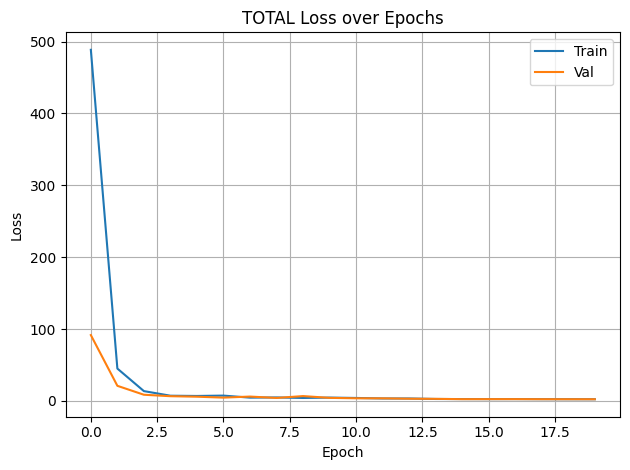

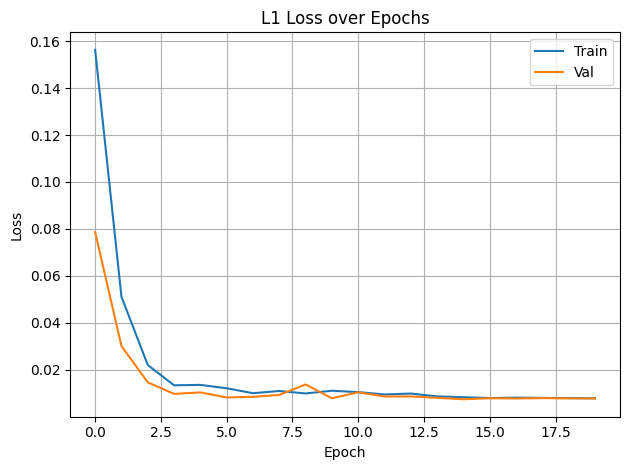

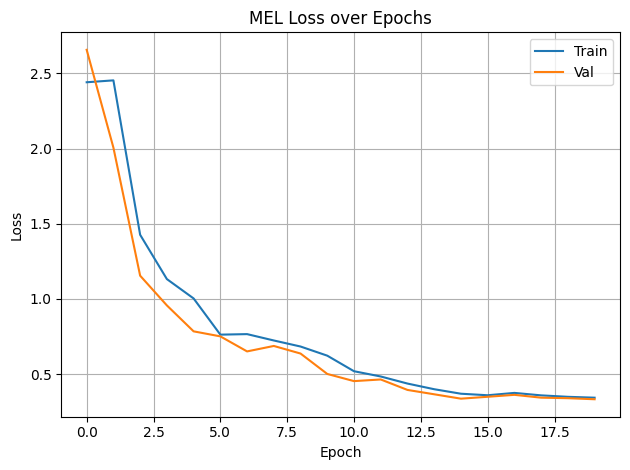

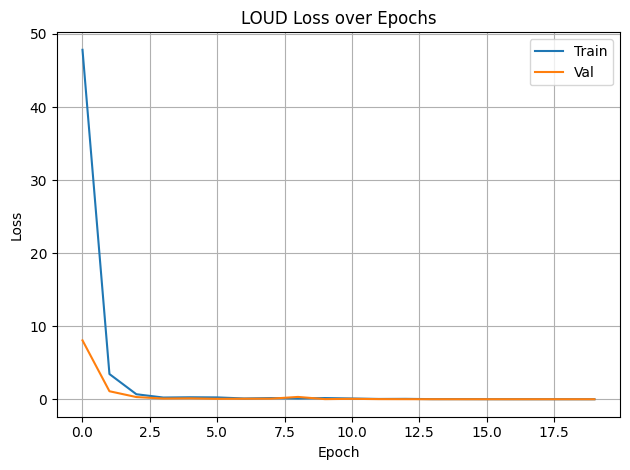

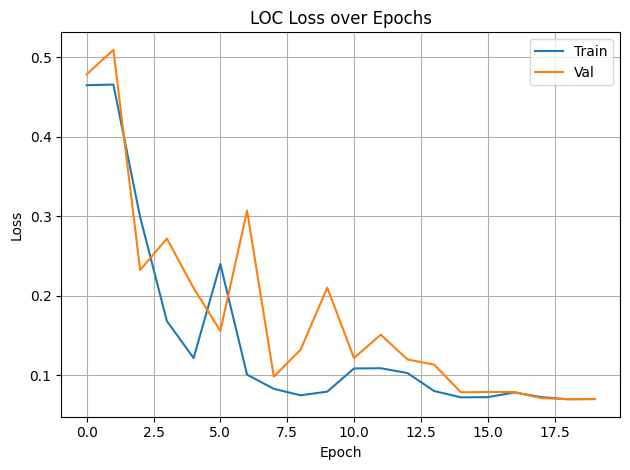

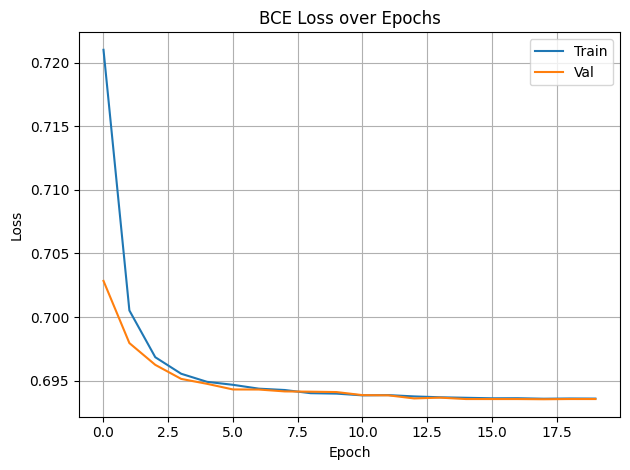

In [15]:
keys = ["total", "l1", "mel", "loud", "loc", "bce"]

for key in keys:
    plt.figure()
    plt.plot([log[key] for log in train_logs], label="Train")
    plt.plot([log[key] for log in val_logs], label="Val")
    plt.title(f"{key.upper()} Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [16]:
# keys = ["total", "l1", "mel", "loud", "loc"]

# for key in keys:
#     plt.figure()
#     plt.plot([log[key] for log in train_logs], label="Train")
#     plt.plot([log[key] for log in val_logs], label="Val")
#     plt.title(f"{key.upper()} Loss over Epochs")
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


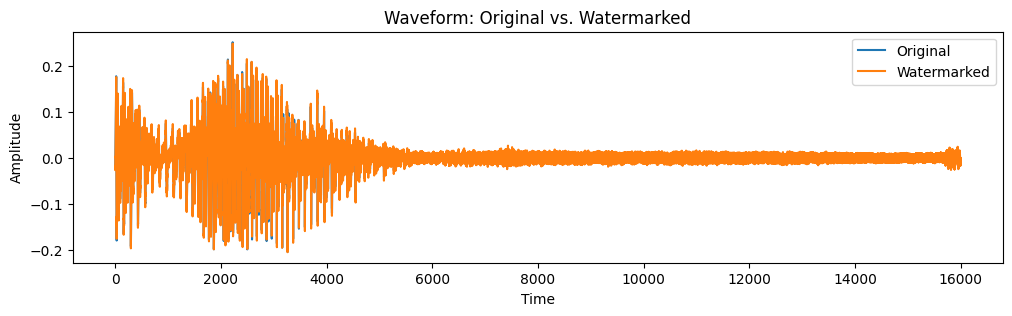

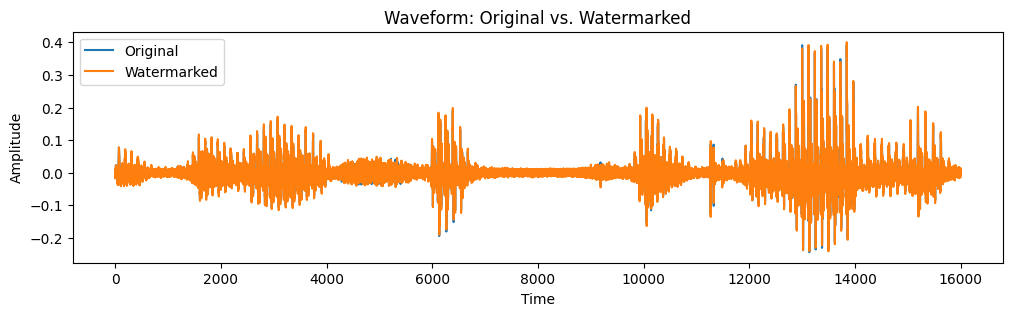

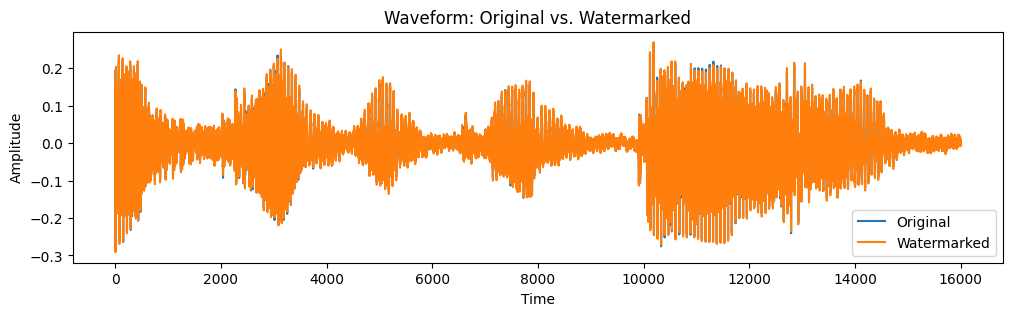

In [21]:

if __name__ == "__main__":
    visualize_delta(generator, val_dataset, device, num_examples=3)

In [8]:
# ---------- adjust paths if you renamed them ---------------------
GEN_PATH = "working/generator_best.pth"
DET_PATH = "working/detector_best.pth"

DEVICE   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MESSAGE_BITS = 16          # keep in sync with training

# 1) build architectures
generator = Generator(message_bits=MESSAGE_BITS).to(DEVICE)
detector  = Detector (message_bits=MESSAGE_BITS).to(DEVICE)

# (optional) keep same compile mode used in training
generator = torch.compile(generator, mode="reduce-overhead")
detector  = torch.compile(detector , mode="reduce-overhead")

# 2) load weights
generator.load_state_dict(torch.load(GEN_PATH, map_location=DEVICE))
detector .load_state_dict(torch.load(DET_PATH,  map_location=DEVICE))
generator.eval(); detector.eval()

print("✓ individual models loaded for inference")


✓ individual models loaded for inference


/tmp/ipykernel_21145/2773056631.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(GEN_PATH, map_location=DEVICE))
/tmp/ipykernel_2114

In [9]:
import os, torch, torchaudio, torch.nn.functional as F
import numpy as np

# ---------- helpers -------------------------------------------------
SAMPLE_RATE  = 16_000
AUDIO_LEN    = 16_000                 # 1-s segments
MESSAGE_BITS = 16                     # must match training

def compute_si_snr(ref: torch.Tensor, est: torch.Tensor, eps=1e-8) -> float:
    """
    Scale-Invariant SNR — expects shapes (1, 1, T)
    """
    s     = ref - ref.mean(-1, keepdim=True)
    s_hat = est - est.mean(-1, keepdim=True)
    dot   = torch.sum(s * s_hat, -1, keepdim=True)
    s_norm= torch.sum(s ** 2, -1, keepdim=True)
    s_target = dot / (s_norm + eps) * s
    e_noise  = s_hat - s_target
    si_snr = 10 * torch.log10(torch.sum(s_target ** 2, -1) /
                              (torch.sum(e_noise ** 2, -1) + eps))
    return si_snr.item()

@torch.no_grad()
def embed_watermark_and_metrics(
        in_path : str,
        out_path: str,
        gen     : torch.nn.Module,
        sr      : int = SAMPLE_RATE,
        msg_bits: int = MESSAGE_BITS,
):
    wav, native_sr = torchaudio.load(in_path)
    if wav.shape[0] > 1:                       # mono
        wav = wav.mean(0, keepdim=True)
    if native_sr != sr:
        wav = torchaudio.transforms.Resample(native_sr, sr)(wav)

    seg_len = sr
    wm_segs, delta_segs = [], []

    for i in range(0, wav.shape[1], seg_len):
        seg = wav[:, i:i+seg_len]
        pad_len = seg_len - seg.shape[1]
        if pad_len > 0:
            seg = F.pad(seg, (0, pad_len))
        seg = seg.to(device).unsqueeze(0)      # (1,1,T)

        msg  = torch.randint(0, 2**msg_bits, (1,), device=device)
        delta= gen(seg, msg)
        wm_segs   .append((seg + delta).squeeze(0).cpu())
        delta_segs.append(delta.squeeze(0).cpu())

    watermarked = torch.cat(wm_segs,   1)[:, :wav.shape[1]]
    delta_full  = torch.cat(delta_segs,1)[:, :wav.shape[1]]

    # --- metrics ---------------------------------------------------
    rms = torch.sqrt((delta_full ** 2).mean()).item()
    si  = compute_si_snr(wav.unsqueeze(0), watermarked.unsqueeze(0))

    # --- save ------------------------------------------------------
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    torchaudio.save(out_path, watermarked, sr)

    print(f"✓ saved water-marked file → {out_path}")
    print(f"Watermark RMS amplitude  : {rms:.6f}")
    print(f"SI-SNR (clean → wm)      : {si:.2f} dB")

    return rms, si


# ---------------- example call ------------------------------------
embed_watermark_and_metrics(
    in_path  = "data/raw_audios/en/2018/20180115-0900-PLENARY-9_en.ogg",
    out_path = "inference_results/why_watermarked.wav",
    gen      = generator,         
)


✓ saved water-marked file → inference_results/why_watermarked.wav
Watermark RMS amplitude  : 0.007642
SI-SNR (clean → wm)      : 20.94 dB


(0.0076421210542321205, 20.9447021484375)

In [ ]:
import torch, torchaudio, torch.nn.functional as F
import numpy as np

# --- constants (same as training) ---------------------------------
SAMPLE_RATE  = 16_000
AUDIO_LEN    = 16_000
THRESHOLD    = 0.5              # ≥ threshold ⇒ “watermarked”

@torch.no_grad()
def detect_watermark(
        file_path : str,
        det       : torch.nn.Module,
        sr        : int   = SAMPLE_RATE,
        thresh    : float = THRESHOLD
):

    wav, native_sr = torchaudio.load(file_path)
    if wav.shape[0] > 1:
        wav = wav.mean(0, keepdim=True)
    if native_sr != sr:
        wav = torchaudio.transforms.Resample(native_sr, sr)(wav)
    wav = wav.to(device)

    seg_len = sr
    probs = []

    for i in range(0, wav.shape[1], seg_len):
        seg = wav[:, i:i+seg_len]
        if seg.shape[1] < seg_len:
            seg = F.pad(seg, (0, seg_len - seg.shape[1]))
        logits = det(seg.unsqueeze(0))             # (1,T,1+bits)
        p = torch.sigmoid(logits[:, :, 0]).mean().item()
        probs.append(p)

    mean_p = float(np.mean(probs))
    is_wm  = mean_p >= thresh
    label  = "WATERMARKED" if is_wm else "clean"

    print(f"{file_path} →  prob = {mean_p:.4f}   ⇒  {label}")
    return mean_p, is_wm



mean_p1, is_wm1 = detect_watermark("inference_results/why_watermarked.wav", detector)
print(f"Returned values: {mean_p1}, {is_wm1}") 


mean_p2, is_wm2 = detect_watermark("data/raw_audios/en/2018/20180115-0900-PLENARY-9_en.ogg", detector)
print(f"Returned values: {mean_p2}, {is_wm2}")  # expected “clean”


inference_results/why_watermarked.wav →  prob = 0.6397   ⇒  WATERMARKED
Returned values: 0.639748458384124, True
data/raw_audios/en/2018/20180115-0900-PLENARY-9_en.ogg →  prob = 0.3460   ⇒  clean
Returned values: 0.3459839688301025, False


/tmp/ipykernel_22314/4108239265.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_state_dict_strip_prefix(generator, torch.load(GENERATOR_WEIGHTS, map_location=devic

Avg Detection Prob (Clean): 0.3243
Avg Detection Prob (Watermarked): 0.6725
Avg SI-SNR: 20.73 dB
Avg Watermark RMS: 0.007744

Classification Report:
              precision    recall  f1-score   support

       Clean       0.99      0.99      0.99     19704
 Watermarked       0.99      0.99      0.99     19704

    accuracy                           0.99     39408
   macro avg       0.99      0.99      0.99     39408
weighted avg       0.99      0.99      0.99     39408



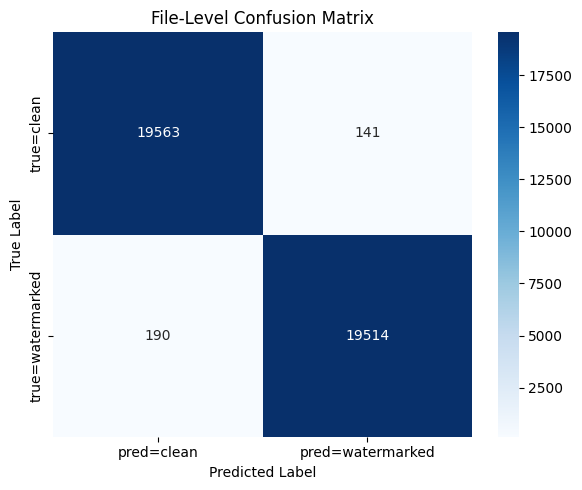

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
def load_state_dict_strip_prefix(model, state_dict, prefix="_orig_mod."):
    new_state_dict = {}
    has_prefix = any(key.startswith(prefix) for key in state_dict.keys())
    if has_prefix:
        for key, val in state_dict.items():
            if key.startswith(prefix):
                new_state_dict[key[len(prefix):]] = val
            else:
                new_state_dict[key] = val
        model.load_state_dict(new_state_dict, strict=False)
    else:
        model.load_state_dict(state_dict)


def compute_si_snr(s, s_hat, eps=1e-8):
    s = s.squeeze(0)
    s_hat = s_hat.squeeze(0)
    s = s - s.mean(dim=-1, keepdim=True)
    s_hat = s_hat - s_hat.mean(dim=-1, keepdim=True)
    dot = torch.sum(s * s_hat, dim=-1, keepdim=True)
    norm_s = torch.sum(s ** 2, dim=-1, keepdim=True)
    alpha = dot / (norm_s + eps)
    s_target = alpha * s
    e_noise = s_hat - s_target
    si_snr = 10 * torch.log10(torch.sum(s_target ** 2, dim=-1) / (torch.sum(e_noise ** 2, dim=-1) + eps))
    return si_snr.mean().item()        

def evaluate_unseen_file(filepath, generator, detector, device):
    try:
        waveform, sr = torchaudio.load(filepath)
    except Exception:
        return None, None, None, None

    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    if sr != SAMPLE_RATE:
        waveform = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(waveform)
    waveform = waveform.to(device)

    clean_probs, wm_probs = [], []
    si_snr_list, rms_list = [], []

    generator.eval(); detector.eval()
    with torch.no_grad():
        for i in range(0, waveform.shape[1], AUDIO_LEN):
            seg = waveform[:, i:i + AUDIO_LEN]
            if seg.shape[1] < AUDIO_LEN:
                seg = F.pad(seg, (0, AUDIO_LEN - seg.shape[1]))
            seg = seg.unsqueeze(0) 
            message = torch.randint(0, 2 ** MESSAGE_BITS, (1,), device=device)
            delta = generator(seg, message)
            seg_w = seg + delta
            logits_clean = detector(seg)[:, :, 0]
            logits_wm    = detector(seg_w)[:, :, 0]
            prob_clean = torch.sigmoid(logits_clean).mean().item()
            prob_wm    = torch.sigmoid(logits_wm).mean().item()
            clean_probs.append(prob_clean)
            wm_probs.append(prob_wm)
            rms_val = torch.sqrt((delta ** 2).mean()).item()
            rms_list.append(rms_val)
            si_val = compute_si_snr(seg, seg_w)
            si_snr_list.append(si_val)

    return (np.mean(clean_probs), np.mean(wm_probs), np.mean(si_snr_list), np.mean(rms_list))

if __name__ == "__main__":
    set_seed(42)

    UNSEEN_DATA_DIR   = "data/test_5_hours"
    GENERATOR_WEIGHTS = "working/generator_best.pth"
    DETECTOR_WEIGHTS  = "working/detector_best.pth"
    AUDIO_EXTENSIONS  = ['.wav', '.mp3', '.flac', '.ogg']
    generator = Generator(message_bits=MESSAGE_BITS).to(device)
    detector  = Detector(message_bits=MESSAGE_BITS).to(device)
    load_state_dict_strip_prefix(generator, torch.load(GENERATOR_WEIGHTS, map_location=device))
    load_state_dict_strip_prefix(detector,  torch.load(DETECTOR_WEIGHTS,  map_location=device))

    # collect files
    all_files = []
    for ext in AUDIO_EXTENSIONS:
        all_files += glob.glob(os.path.join(UNSEEN_DATA_DIR, '**', f'*{ext}'), recursive=True)

    # evaluate
    all_clean, all_wm, all_si, all_rms = [], [], [], []
    for f in tqdm(all_files, desc="Evaluating Files"):
        c, w, si, rms = evaluate_unseen_file(f, generator, detector, device)
        if c is not None:
            all_clean.append(c); all_wm.append(w)
            all_si.append(si); all_rms.append(rms)

    overall_clean = np.mean(all_clean)
    overall_wm    = np.mean(all_wm)
    overall_si    = np.mean(all_si)
    overall_rms   = np.mean(all_rms)

    print(f"Avg Detection Prob (Clean): {overall_clean:.4f}")
    print(f"Avg Detection Prob (Watermarked): {overall_wm:.4f}")
    print(f"Avg SI-SNR: {overall_si:.2f} dB")
    print(f"Avg Watermark RMS: {overall_rms:.6f}")
    thresh = 0.5
    y_true = [0]*len(all_clean) + [1]*len(all_wm)
    y_pred = [1 if p>=thresh else 0 for p in all_clean] + [1 if p>=thresh else 0 for p in all_wm]

    cm = confusion_matrix(y_true, y_pred)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["Clean", "Watermarked"]))

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['pred=clean','pred=watermarked'],
                yticklabels=['true=clean','true=watermarked'])
    plt.title('File-Level Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

Embedding audio:   0%|          | 0/19704 [00:00<?, ?it/s]


Avg RMS      : 0.007729
Avg SI-SNR   : 20.69 dB



Detecting watermark:   0%|          | 0/19704 [00:00<?, ?it/s]

Detecting watermark:   0%|          | 0/19704 [00:00<?, ?it/s]

Detection Accuracy: 0.9913

              precision    recall  f1-score   support

       clean     0.9898    0.9928    0.9913     19704
 watermarked     0.9928    0.9897    0.9913     19704

    accuracy                         0.9913     39408
   macro avg     0.9913    0.9913    0.9913     39408
weighted avg     0.9913    0.9913    0.9913     39408



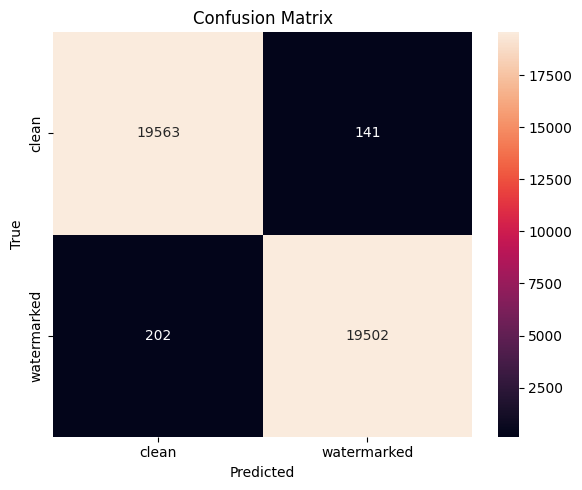

In [14]:
import os, glob
import torch, torchaudio, torch.nn.functional as F
import numpy as np

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# ───── constants ───────────────────────────────────────────────────────────────
SAMPLE_RATE  = 16_000
MESSAGE_BITS = 16
THRESHOLD    = 0.5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# assume `generator` and `detector` are already loaded & moved to `device`

# ───── core single-file functions ───────────────────────────────────────────────
def compute_si_snr(ref: torch.Tensor, est: torch.Tensor, eps=1e-8) -> float:
    s     = ref - ref.mean(-1, keepdim=True)
    s_hat = est - est.mean(-1, keepdim=True)
    dot   = torch.sum(s * s_hat, -1, keepdim=True)
    s_norm= torch.sum(s ** 2, -1, keepdim=True)
    s_target = dot / (s_norm + eps) * s
    e_noise  = s_hat - s_target
    si_snr = 10 * torch.log10(torch.sum(s_target ** 2, -1) /
                              (torch.sum(e_noise ** 2, -1) + eps))
    return si_snr.item()

@torch.no_grad()
def embed_watermark_and_metrics(
        in_path : str,
        out_path: str,
        gen     : torch.nn.Module,
        sr      : int = SAMPLE_RATE,
        msg_bits: int = MESSAGE_BITS,
):
    wav, native_sr = torchaudio.load(in_path)
    if wav.shape[0] > 1:
        wav = wav.mean(0, keepdim=True)
    if native_sr != sr:
        wav = torchaudio.transforms.Resample(native_sr, sr)(wav)

    seg_len = sr
    wm_segs, delta_segs = [], []

    for i in range(0, wav.shape[1], seg_len):
        seg = wav[:, i:i+seg_len]
        pad = seg_len - seg.shape[1]
        if pad > 0:
            seg = F.pad(seg, (0, pad))
        seg = seg.to(device).unsqueeze(0)
        msg  = torch.randint(0, 2**msg_bits, (1,), device=device)
        delta= gen(seg, msg)
        wm_segs.append((seg + delta).squeeze(0).cpu())
        delta_segs.append(delta.squeeze(0).cpu())

    watermarked = torch.cat(wm_segs, 1)[:, :wav.shape[1]]
    delta_full  = torch.cat(delta_segs, 1)[:, :wav.shape[1]]

    rms = float(torch.sqrt((delta_full**2).mean()).item())
    si  = compute_si_snr(wav.unsqueeze(0), watermarked.unsqueeze(0))

    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    torchaudio.save(out_path, watermarked, sr)

    return rms, si

@torch.no_grad()
def detect_watermark(
        file_path : str,
        det       : torch.nn.Module,
        sr        : int   = SAMPLE_RATE,
        thresh    : float = THRESHOLD
):
    wav, native_sr = torchaudio.load(file_path)
    if wav.shape[0] > 1:
        wav = wav.mean(0, keepdim=True)
    if native_sr != sr:
        wav = torchaudio.transforms.Resample(native_sr, sr)(wav)
    wav = wav.to(device)

    seg_len = sr
    probs = []
    for i in range(0, wav.shape[1], seg_len):
        seg = wav[:, i:i+seg_len]
        if seg.shape[1] < seg_len:
            seg = F.pad(seg, (0, seg_len - seg.shape[1]))
        logits = det(seg.unsqueeze(0))
        p = torch.sigmoid(logits[:, :, 0]).mean().item()
        probs.append(p)

    mean_p = float(np.mean(probs))
    is_wm  = mean_p >= thresh
    return mean_p, is_wm

# ───── batch wrappers + evaluation ─────────────────────────────────────────────
def embed_watermark_folder(input_dir, output_dir, gen):
    rms_list, si_list = [], []
    # gather all files first
    files = []
    for ext in ("*.wav","*.ogg","*.flac"):
        files.extend(glob.glob(os.path.join(input_dir, ext)))
    # progress bar over files
    for in_path in tqdm(files, desc="Embedding audio"):
        fn  = os.path.basename(in_path)
        out = os.path.join(output_dir, fn)
        r, s = embed_watermark_and_metrics(in_path, out, gen)
        rms_list.append(r)
        si_list.append(s)
    avg_rms = np.mean(rms_list)
    avg_si  = np.mean(si_list)
    print(f"\nAvg RMS      : {avg_rms:.6f}")
    print(f"Avg SI-SNR   : {avg_si:.2f} dB\n")
    return rms_list, si_list

def detect_watermark_folder(input_dir, det):
    preds = []
    files = []
    for ext in ("*.wav","*.ogg","*.flac"):
        files.extend(glob.glob(os.path.join(input_dir, ext)))
    for file_path in tqdm(files, desc="Detecting watermark"):
        _, is_wm = detect_watermark(file_path, det)
        preds.append((file_path, is_wm))
    return preds

# ───── run the pipeline ───────────────────────────────────────────────────────
embed_rms, embed_si = embed_watermark_folder(
    input_dir="data/test_5_hours",
    output_dir="inference_results/batch_watermarked",
    gen=generator
)

wm_preds    = detect_watermark_folder("inference_results/batch_watermarked", detector)
clean_preds = detect_watermark_folder("data/test_5_hours", detector)

# evaluation
y_true, y_pred = [], []
for _, p in wm_preds:    y_true.append(1); y_pred.append(int(p))
for _, p in clean_preds: y_true.append(0); y_pred.append(int(p))

acc = accuracy_score(y_true, y_pred)
print(f"Detection Accuracy: {acc:.4f}\n")
print(classification_report(
    y_true, y_pred,
    target_names=["clean", "watermarked"],
    digits=4
))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["clean","watermarked"],
            yticklabels=["clean","watermarked"])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [1]:
import os, glob
import torch, torchaudio, torch.nn.functional as F
import numpy as np

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm  # standard tqdm

# ───── constants ───────────────────────────────────────────────────────────────
SAMPLE_RATE  = 16_000
MESSAGE_BITS = 16
THRESHOLD    = 0.5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# assume `generator` and `detector` are already loaded & moved to `device`

# ───── core single-file functions ───────────────────────────────────────────────
def compute_si_snr(ref: torch.Tensor, est: torch.Tensor, eps=1e-8) -> float:
    s     = ref - ref.mean(-1, keepdim=True)
    s_hat = est - est.mean(-1, keepdim=True)
    dot   = torch.sum(s * s_hat, -1, keepdim=True)
    s_norm= torch.sum(s ** 2, -1, keepdim=True)
    s_target = dot / (s_norm + eps) * s
    e_noise  = s_hat - s_target
    si_snr = 10 * torch.log10(torch.sum(s_target ** 2, -1) /
                              (torch.sum(e_noise ** 2, -1) + eps))
    return si_snr.item()

@torch.no_grad()
def embed_watermark_and_metrics(
        in_path: str,
        out_path: str,
        gen: torch.nn.Module,
        sr: int = SAMPLE_RATE,
        msg_bits: int = MESSAGE_BITS,
):
    wav, native_sr = torchaudio.load(in_path)
    if wav.shape[0] > 1:
        wav = wav.mean(0, keepdim=True)
    if native_sr != sr:
        wav = torchaudio.transforms.Resample(native_sr, sr)(wav)

    seg_len = sr
    wm_segs, delta_segs = [], []

    for i in range(0, wav.shape[1], seg_len):
        seg = wav[:, i:i+seg_len]
        pad = seg_len - seg.shape[1]
        if pad > 0:
            seg = F.pad(seg, (0, pad))
        seg = seg.to(device).unsqueeze(0)
        msg  = torch.randint(0, 2**msg_bits, (1,), device=device)
        delta= gen(seg, msg)
        wm_segs.append((seg + delta).squeeze(0).cpu())
        delta_segs.append(delta.squeeze(0).cpu())

    watermarked = torch.cat(wm_segs, 1)[:, :wav.shape[1]]
    delta_full  = torch.cat(delta_segs, 1)[:, :wav.shape[1]]

    rms = float(torch.sqrt((delta_full ** 2).mean()).item())
    si  = compute_si_snr(wav.unsqueeze(0), watermarked.unsqueeze(0))

    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    torchaudio.save(out_path, watermarked, sr)

    return rms, si

@torch.no_grad()
def detect_watermark(
        file_path: str,
        det: torch.nn.Module,
        sr: int = SAMPLE_RATE,
        thresh: float = THRESHOLD
):
    wav, native_sr = torchaudio.load(file_path)
    if wav.shape[0] > 1:
        wav = wav.mean(0, keepdim=True)
    if native_sr != sr:
        wav = torchaudio.transforms.Resample(native_sr, sr)(wav)
    wav = wav.to(device)

    seg_len = sr
    probs = []
    for i in range(0, wav.shape[1], seg_len):
        seg = wav[:, i:i+seg_len]
        if seg.shape[1] < seg_len:
            seg = F.pad(seg, (0, seg_len - seg.shape[1]))
        logits = det(seg.unsqueeze(0))
        p = torch.sigmoid(logits[:, :, 0]).mean().item()
        probs.append(p)

    mean_p = float(np.mean(probs))
    is_wm  = mean_p >= thresh
    return mean_p, is_wm

# ───── batch wrappers + evaluation ─────────────────────────────────────────────
def embed_watermark_folder(input_dir, output_dir, gen):
    rms_list, si_list = [], []
    files = []
    for ext in ("*.wav", "*.ogg", "*.flac"):
        files.extend(glob.glob(os.path.join(input_dir, ext)))
    for in_path in tqdm(files, desc="Embedding audio"):
        fn  = os.path.basename(in_path)
        out = os.path.join(output_dir, fn)
        r, s = embed_watermark_and_metrics(in_path, out, gen)
        rms_list.append(r)
        si_list.append(s)
    avg_rms = np.mean(rms_list)
    avg_si  = np.mean(si_list)
    print(f"\nAvg RMS    : {avg_rms:.6f}")
    print(f"Avg SI-SNR : {avg_si:.2f} dB\n")
    return rms_list, si_list

def detect_watermark_folder(input_dir, det):
    preds = []
    files = []
    for ext in ("*.wav", "*.ogg", "*.flac"):
        files.extend(glob.glob(os.path.join(input_dir, ext)))
    for file_path in tqdm(files, desc="Detecting watermark"):
        _, is_wm = detect_watermark(file_path, det)
        preds.append((file_path, is_wm))
    return preds

# ───── run the pipeline ───────────────────────────────────────────────────────
embed_rms, embed_si = embed_watermark_folder(
    input_dir="data/raw_audios/en/2018",
    output_dir="inference_results/batch_watermarked",
    gen=generator
)

wm_preds    = detect_watermark_folder("inference_results/batch_watermarked", detector)
clean_preds = detect_watermark_folder("data/raw_audios/en/2018", detector)

# evaluation
y_true, y_pred = [], []
for _, p in wm_preds:    y_true.append(1); y_pred.append(int(p))
for _, p in clean_preds: y_true.append(0); y_pred.append(int(p))

acc = accuracy_score(y_true, y_pred)
print(f"Detection Accuracy: {acc:.4f}\n")
print(classification_report(
    y_true, y_pred,
    target_names=["clean", "watermarked"],
    digits=4
))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["clean","watermarked"],
            yticklabels=["clean","watermarked"])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


NameError: name 'generator' is not defined

/tmp/ipykernel_27252/369077870.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_state_dict_strip_prefix(generator, torch.load(GENERATOR_WEIGHTS, map_location=device

Avg Detection Prob (Clean): 0.2861
Avg Detection Prob (Watermarked): 0.7168
Avg SI-SNR: -inf dB
Avg Watermark RMS: 0.008253

Classification Report:
              precision    recall  f1-score   support

       Clean       1.00      0.99      0.99      2703
 Watermarked       0.99      1.00      0.99      2703

    accuracy                           0.99      5406
   macro avg       0.99      0.99      0.99      5406
weighted avg       0.99      0.99      0.99      5406



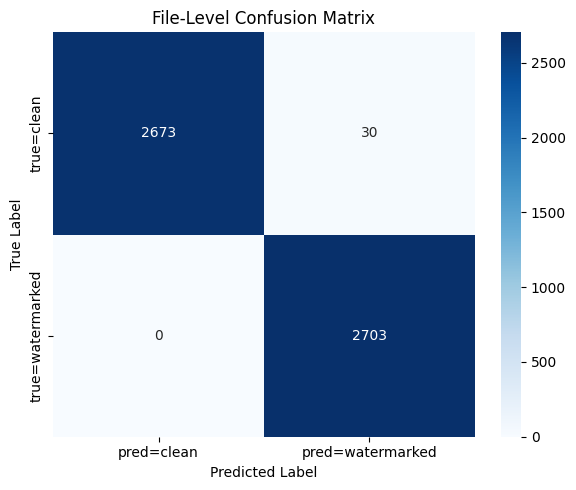

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
def load_state_dict_strip_prefix(model, state_dict, prefix="_orig_mod."):
    new_state_dict = {}
    has_prefix = any(key.startswith(prefix) for key in state_dict.keys())
    if has_prefix:
        for key, val in state_dict.items():
            if key.startswith(prefix):
                new_state_dict[key[len(prefix):]] = val
            else:
                new_state_dict[key] = val
        model.load_state_dict(new_state_dict, strict=False)
    else:
        model.load_state_dict(state_dict)


def compute_si_snr(s, s_hat, eps=1e-8):
    s = s.squeeze(0)
    s_hat = s_hat.squeeze(0)
    s = s - s.mean(dim=-1, keepdim=True)
    s_hat = s_hat - s_hat.mean(dim=-1, keepdim=True)
    dot = torch.sum(s * s_hat, dim=-1, keepdim=True)
    norm_s = torch.sum(s ** 2, dim=-1, keepdim=True)
    alpha = dot / (norm_s + eps)
    s_target = alpha * s
    e_noise = s_hat - s_target
    si_snr = 10 * torch.log10(torch.sum(s_target ** 2, dim=-1) / (torch.sum(e_noise ** 2, dim=-1) + eps))
    return si_snr.mean().item()        

def evaluate_unseen_file(filepath, generator, detector, device):
    try:
        waveform, sr = torchaudio.load(filepath)
    except Exception:
        return None, None, None, None

    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    if sr != SAMPLE_RATE:
        waveform = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(waveform)
    waveform = waveform.to(device)

    clean_probs, wm_probs = [], []
    si_snr_list, rms_list = [], []

    generator.eval(); detector.eval()
    with torch.no_grad():
        for i in range(0, waveform.shape[1], AUDIO_LEN):
            seg = waveform[:, i:i + AUDIO_LEN]
            if seg.shape[1] < AUDIO_LEN:
                seg = F.pad(seg, (0, AUDIO_LEN - seg.shape[1]))
            seg = seg.unsqueeze(0) 
            message = torch.randint(0, 2 ** MESSAGE_BITS, (1,), device=device)
            delta = generator(seg, message)
            seg_w = seg + delta
            logits_clean = detector(seg)[:, :, 0]
            logits_wm    = detector(seg_w)[:, :, 0]
            prob_clean = torch.sigmoid(logits_clean).mean().item()
            prob_wm    = torch.sigmoid(logits_wm).mean().item()
            clean_probs.append(prob_clean)
            wm_probs.append(prob_wm)
            rms_val = torch.sqrt((delta ** 2).mean()).item()
            rms_list.append(rms_val)
            si_val = compute_si_snr(seg, seg_w)
            si_snr_list.append(si_val)

    return (np.mean(clean_probs), np.mean(wm_probs), np.mean(si_snr_list), np.mean(rms_list))

if __name__ == "__main__":
    set_seed(42)

    UNSEEN_DATA_DIR   = "data/dev-clean/LibriSpeech/dev-clean"
    GENERATOR_WEIGHTS = "working/generator_best.pth"
    DETECTOR_WEIGHTS  = "working/detector_best.pth"
    AUDIO_EXTENSIONS  = ['.wav', '.mp3', '.flac', '.ogg']
    generator = Generator(message_bits=MESSAGE_BITS).to(device)
    detector  = Detector(message_bits=MESSAGE_BITS).to(device)
    load_state_dict_strip_prefix(generator, torch.load(GENERATOR_WEIGHTS, map_location=device))
    load_state_dict_strip_prefix(detector,  torch.load(DETECTOR_WEIGHTS,  map_location=device))

    # collect files
    all_files = []
    for ext in AUDIO_EXTENSIONS:
        all_files += glob.glob(os.path.join(UNSEEN_DATA_DIR, '**', f'*{ext}'), recursive=True)

    # evaluate
    all_clean, all_wm, all_si, all_rms = [], [], [], []
    for f in tqdm(all_files, desc="Evaluating Files"):
        c, w, si, rms = evaluate_unseen_file(f, generator, detector, device)
        if c is not None:
            all_clean.append(c); all_wm.append(w)
            all_si.append(si); all_rms.append(rms)

    overall_clean = np.mean(all_clean)
    overall_wm    = np.mean(all_wm)
    overall_si    = np.mean(all_si)
    overall_rms   = np.mean(all_rms)

    print(f"Avg Detection Prob (Clean): {overall_clean:.4f}")
    print(f"Avg Detection Prob (Watermarked): {overall_wm:.4f}")
    print(f"Avg SI-SNR: {overall_si:.2f} dB")
    print(f"Avg Watermark RMS: {overall_rms:.6f}")
    thresh = 0.5
    y_true = [0]*len(all_clean) + [1]*len(all_wm)
    y_pred = [1 if p>=thresh else 0 for p in all_clean] + [1 if p>=thresh else 0 for p in all_wm]

    cm = confusion_matrix(y_true, y_pred)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["Clean", "Watermarked"]))

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['pred=clean','pred=watermarked'],
                yticklabels=['true=clean','true=watermarked'])
    plt.title('File-Level Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()